# Exercise 1

Consider the following matrix $ X \in \mathbb{R}^{400 \times 400} $ defined as:

$$
X_{ij} =
\begin{cases}
110 & \text{if } 50 \leq i \leq 150, 30 \leq j \leq 130, \\
150 & \text{if } 50 \leq i \leq 150, 230 \leq j \leq 330, \\
180 & \text{if } 250 \leq i \leq 350, 70 \leq j \leq 170, \\
220 & \text{if } 250 \leq i \leq 350, 270 \leq j \leq 370, \\
0 & \text{elsewhere,}
\end{cases}
$$

where $ i, j = 1, \ldots, 400 $.


1. **Add Synthetic Noise**  
   Add synthetic noise to $ X $ by sampling from a Gaussian distribution with zero mean and standard deviation $ \sigma = 0.2 $.

2. **Singular Value Truncation (SVT)**  
   Implement the singular value truncation (SVT) algorithm and apply it to reconstruct the original matrix $ X $ from $ X_{\text{noise}} $.  
   - Set a maximum number of iterations equal to 50.  
   - Set a tolerance on the increment equal to $ 10^{-6} $.  
   - Optimize the threshold on the singular values by trial and error.  
   - Compute the relative reconstruction error between $ X $ and the approximation $ \hat{X} $, defined as:  

     $$
     \epsilon_R = \frac{\| X - \hat{X} \|_F}{\| X \|_F},
     $$

     where $ \| \cdot \|_F $ denotes the Frobenius norm.  
   - Report the rank $ \hat{r} $ of $ \hat{X} $.  
   - Visualize the true image and its approximation.

3. **Exact SVD**  
   Using exact SVD, find the value of $ k $ that provides a relative reconstruction error equal to the one obtained in the previous point. Comment on the results.

4. **Randomized SVD**  
   Repeat the previous point using randomized SVD. Comment on the results.


1. **Add Synthetic Noise**  
   Add synthetic noise to $ X $ by sampling from a Gaussian distribution with zero mean and standard deviation $ \sigma = 0.2 $.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize matrix X of size 400x400 with zeros
X = np.zeros((400, 400))

# Fill the matrix as per the given conditions
X[50:151, 30:131] = 110  # Section 1
X[50:151, 230:331] = 150  # Section 2
X[250:351, 70:171] = 180  # Section 3
X[250:351, 270:371] = 220  # Section 4

# Add Sintetic Gaussian noise
np.random.seed(0)
noise = np.random.normal(0, 0.2, X.shape)
X_noise = X + noise

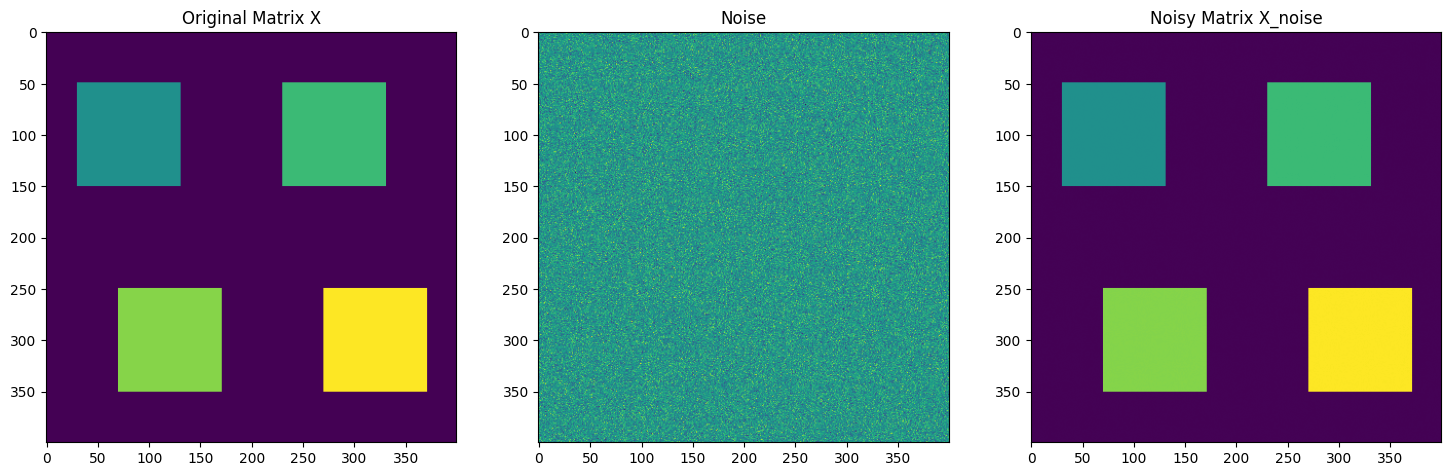

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot X
axs[0].imshow(X)
axs[0].set_title('Original Matrix X')

# Plot noise
axs[1].imshow(noise)
axs[1].set_title('Noise')

# Plot X_noise
axs[2].imshow(X_noise)
axs[2].set_title('Noisy Matrix X_noise')

plt.show()

2. **Singular Value Truncation (SVT)**  
   Implement the singular value truncation (SVT) algorithm and apply it to reconstruct the original matrix $ X $ from $ X_{\text{noise}} $.  
   - Set a maximum number of iterations equal to 50.  
   - Set a tolerance on the increment equal to $ 10^{-6} $.  
   - Optimize the threshold on the singular values by trial and error.  
   - Compute the relative reconstruction error between $ X $ and the approximation $ \hat{X} $, defined as:  

     $$
     \epsilon_R = \frac{\| X - \hat{X} \|_F}{\| X \|_F},
     $$

     where $ \| \cdot \|_F $ denotes the Frobenius norm.  
   - Report the rank $ \hat{r} $ of $ \hat{X} $.  
   - Visualize the true image and its approximation.

**Personal Note:**
The description of the problem is unclear on one core aspect: what values of X_noise can we assume to not being modified? I will assume that no value of X_noise is known and I will use the original X only to compute the relative reconstruction error (which is a metric we have only if we have the original data).



In [4]:
def SVT(X_noise, X, threshold, mask_keep, n_max_iter=100, increment_tol=1e-6): 
    errors = list()
    A = X_noise.copy()
    
    for i in range(n_max_iter):
        A_old = A.copy()

        # Singular Value Thresholding 
        U,s,VT = np.linalg.svd(A, full_matrices = False)
        s[s < threshold] = 0

        # Reconstruct the matrix
        A = U @ np.diag(s) @ VT  
        # Add the known values to the matrix (in our case we do not know them)
        A[mask_keep] = X[mask_keep]

        # Compute the increment and the error
        increment = np.linalg.norm(A - A_old)
        errors.append(np.linalg.norm(X-A)/np.linalg.norm(X))

        # add the reconstruciton error to the matrix
        if np.linalg.norm(A)==0:
            print('k=', threshold, 'removed all singular values')
            return A, errors
        
        # exit condition if the increment is too small
        if increment < increment_tol:
            break
    return A, errors

  0%|          | 0/24 [00:00<?, ?it/s]

k= 32768 removed all singular values


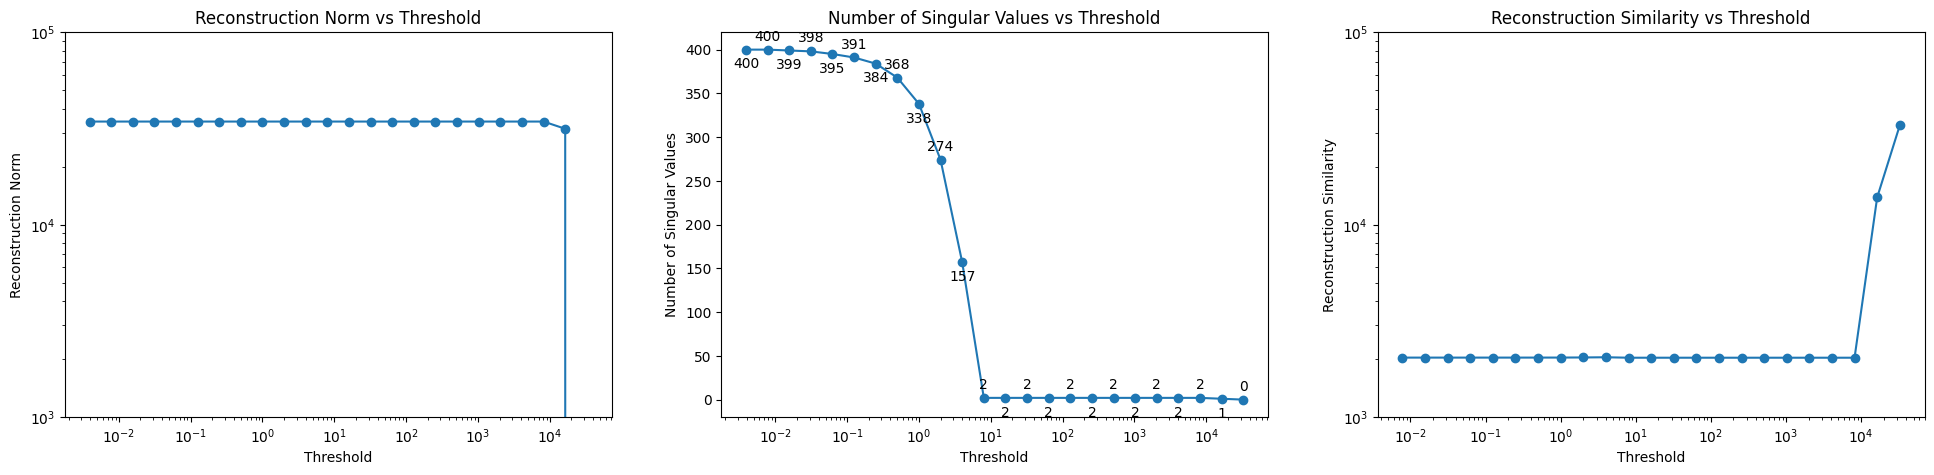

In [5]:
from tqdm.notebook import tqdm


mask_keep = np.zeros_like(X)!=0 # keep no values because we assume to reconstruct X without any prior information on it
                                # So i will get a mask keep with all False values
                                # Note that this is just my assumtion, it is not clear from the text


# Test the SVT function with multiple thresholds
thresholds = [2**i for i in range(-8, 16)]
th_errors = []
reconstructions = []

# Perform SVT for each threshold
for i in tqdm(range(len(thresholds))):
    X_reconstructed, errors = SVT(X_noise, X, thresholds[i], np.zeros_like(X)!=0)
    th_errors.append(errors[-1])
    reconstructions.append(X_reconstructed)

# Select the best threshold based on the pure SVT result (assuming no prior information on X)
reconstruction_norms = [np.linalg.norm(X_reconstructed) for X_reconstructed in reconstructions]
mantained_sing_vals = [np.sum(np.linalg.svd(reconstructions[i], compute_uv=False)>thresholds[i]) for i in range(len(reconstructions))]
reconstruction_similarty = [(1/len(reconstructions))*np.sum([np.linalg.norm(X1 - X2) for X1 in reconstructions]) for X2 in reconstructions[1:]]

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(24, 5))
axs[0].plot(thresholds, reconstruction_norms, marker='o')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('Threshold')
axs[0].set_ylabel('Reconstruction Norm')
axs[0].set_title('Reconstruction Norm vs Threshold')
axs[0].set_ylim([1e3, 1e5])
axs[1].plot(thresholds, mantained_sing_vals, marker='o')
for i, txt in enumerate(mantained_sing_vals):
    axs[1].annotate(f'{txt}', (thresholds[i], int(mantained_sing_vals[i])), textcoords="offset points", xytext=(0,20*(i%2-0.67)), ha='center')
axs[1].set_xscale('log')
axs[1].set_xlabel('Threshold')
axs[1].set_ylabel('Number of Singular Values')
axs[1].set_title('Number of Singular Values vs Threshold')
axs[2].plot(thresholds[1:], reconstruction_similarty, marker='o')
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel('Threshold')
axs[2].set_ylabel('Reconstruction Similarity')
axs[2].set_title('Reconstruction Similarity vs Threshold')
axs[2].set_ylim([1e3, 1e5])

plt.show()

#### Comment: 
From an empirical analysis even without considering the values in the true X is it clear that between the 3rd highest threshold (th = 8192) and the 13th (8) we obtain the same best results.
This conclusion comes from the fact that:
- The norm of the matrix almost do not vary after lowering the threshold (the reconstruction is similar to the others)
- The rank of the matrix increases after lowering the threshold (the reconstruction is likely less noisy)
- The relative norm with respect to other reconstruction is almost flat for lower thresholds meaning (the reconstruction is similar to the others but with less singular values)

This can also be seen from the next cell code in which we exploit also the prior knowledge about X

Text(0.5, 1.0, 'Low values close up')

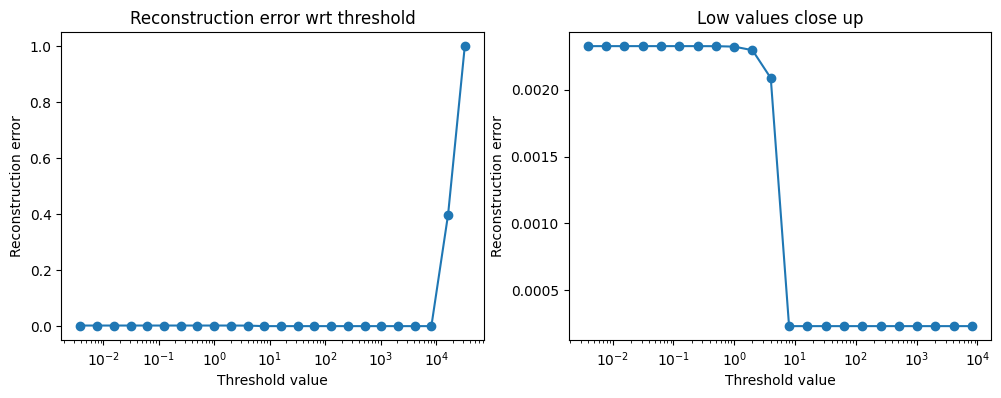

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))


axs[0].plot(thresholds, th_errors, marker='o')
axs[0].set_xscale('log')
axs[0].set_xlabel('Threshold value')
axs[0].set_ylabel('Reconstruction error')
axs[0].set_title('Reconstruction error wrt threshold')

axs[1].plot(thresholds[:-2], th_errors[:-2], marker='o')
axs[1].set_xscale('log')
axs[1].set_xlabel('Threshold value')
axs[1].set_ylabel('Reconstruction error')
axs[1].set_title('Low values close up')


#### Comment: 
From this last plot it is clear how the reconstruction error is best for threshold values between 8 and 8192 (values when the reconstracted matrix is the same rank-2 matrix). 

Threshold value:  8192
Rank:  2
Reconstruction error:  0.0002326336918953167


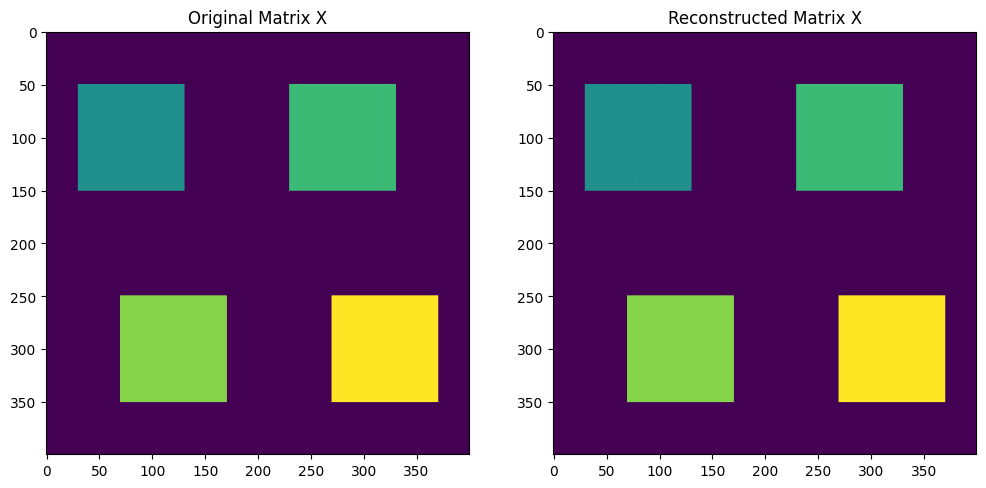

In [7]:
# choosing a threshold value of 8192 as the best value we display all important informations
print('Threshold value: ', thresholds[-3])
print('Rank: ', mantained_sing_vals[-3])
print('Reconstruction error: ', th_errors[-3])

# plot original and reconstructed images
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(X)
axs[0].set_title('Original Matrix X')
axs[1].imshow(reconstructions[-3])
axs[1].set_title('Reconstructed Matrix X')
plt.show()

3. **Exact SVD**  
   Using exact SVD, find the value of $ k $ that provides a relative reconstruction error equal to the one obtained in the previous point. Comment on the results.

SVT reconstruction error:  0.0002326336918953167
SVD reconstruction error:  0.0002326336918953167


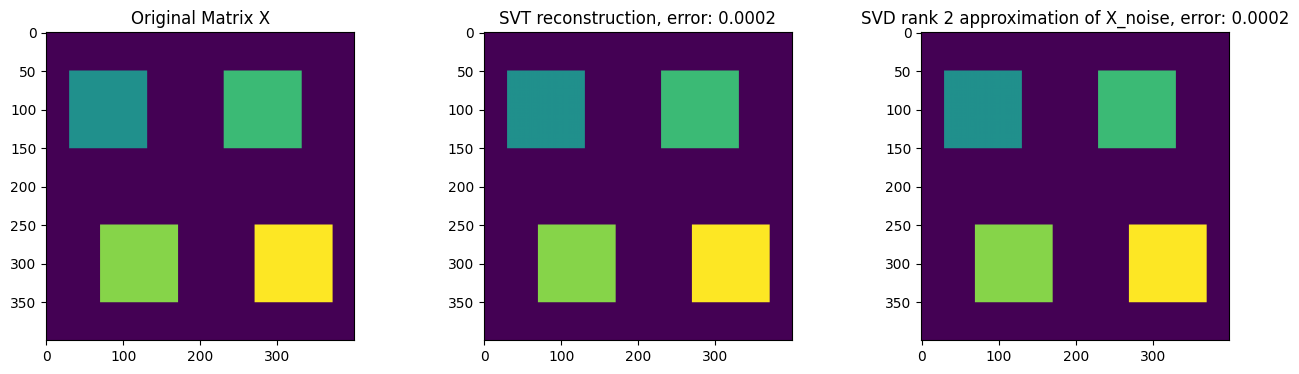

In [8]:
U, s, VT = np.linalg.svd(X_noise)

# Given that the best threshold values reported rank 2 matrixes we can compare the result obtained by
# SVD when we keep only the first 2 singular values to the result obtained by SVT with threshold 8192 (or values between 8 and 8192)

# Compute the rank 2 approximation of X_noise
X_noise_rank2 = U[:, :2] @ np.diag(s[:2]) @ VT[:2, :]
X_noise_rank2_errors = np.linalg.norm(X-X_noise_rank2)/np.linalg.norm(X)

print('SVT reconstruction error: ', th_errors[-3])
print('SVD reconstruction error: ', th_errors[-3])

# plot original and reconstructed images
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(X)
axs[0].set_title('Original Matrix X')
axs[1].imshow(reconstructions[-3])
axs[1].set_title(f'SVT reconstruction, error: {th_errors[-3]:.4f}')
axs[2].imshow(X_noise_rank2)
axs[2].set_title(f'SVD rank 2 approximation of X_noise, error: {X_noise_rank2_errors:.4f}')
plt.show()

#### Comment:

We can see that the two reconstructions are identical, this is due to the fact that we have applied SVT with an empty set of values to keep (mask_keep has no true values). This implies that SVT will perform a single iteration and will return the same result as the exact SVD.
This also implies that the best threshold for SVT can be found by looking at the values of the 2nd and 3rd singular values of the original matrix.
So...

In [9]:
U, s, VT = np.linalg.svd(X_noise)
print(f'Oprimal threshold value for SVT is in ({s[1]}, {s[2]})')

Oprimal threshold value for SVT is in (13671.210658246013, 7.803083896426738)


4. **Randomized SVD**  
   Repeat the previous point using randomized SVD. Comment on the results.

In [10]:
def randomized_SVD(A, k):
  n, m = A.shape[0], A.shape[1]
  P = np.random.randn(m, k)
  Z = A @ P
  Q, R = np.linalg.qr(Z)
  Y = Q.T @ A
  U_Y, s, VT = np.linalg.svd(Y, full_matrices = False)
  U = Q @ U_Y
  return U, s, VT

  0%|          | 0/1000 [00:00<?, ?it/s]

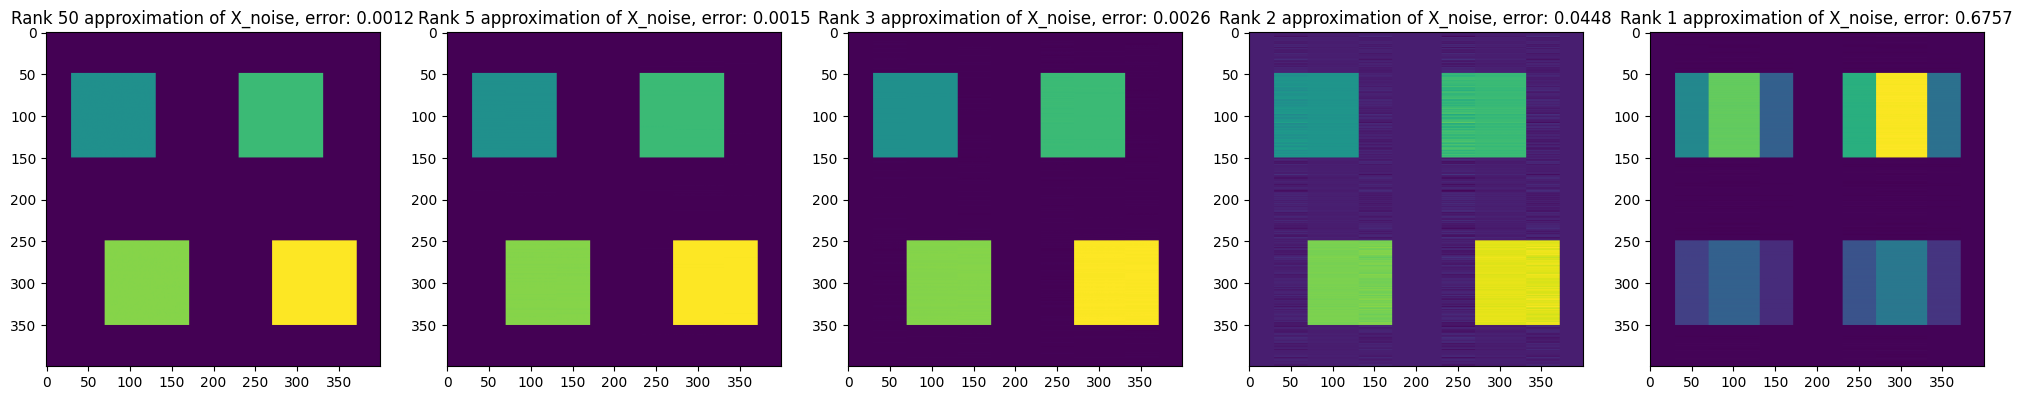

In [11]:
k_r = [50, 5, 3, 2, 1]
np.random.seed(42) # for reproducibility

fig, axes = plt.subplots(nrows = 1, ncols = len(k_r), figsize = (25, 5))
i=0
for k in k_r:
    U, s, VT = randomized_SVD(X_noise, k)
    X_noise_rank_k = U[:, :k] @ np.diag(s[:k]) @ VT[:k, :]
    X_noise_rank_k_errors = np.linalg.norm(X-X_noise_rank_k)/np.linalg.norm(X)
    axes[i].imshow(X_noise_rank_k)
    axes[i].set_title(f'Rank {k} approximation of X_noise, error: {X_noise_rank_k_errors:.4f}')
    i+=1

# ensures that when keeping higher rank the approximation is always very low
rank = 10
for _ in tqdm(range(1000)):
    U, s, VT = randomized_SVD(X_noise, rank)
    X_noise_rank_k = U[:, :rank] @ np.diag(s[:rank]) @ VT[:rank, :]
    X_noise_rank_k_errors = np.linalg.norm(X-X_noise_rank_k)/np.linalg.norm(X)
    assert X_noise_rank_k_errors < 0.01

#### Comment:

The results are very close to the ones obtained with the exact SVD, however due to the randomness of the algorithm it may happen that for k=2 the results are not consistent with the exact SVD (or SVT).
Using a higher value of k (e.g. 10) ensures (with extremely high probability) that the results are consistent with the exact SVD (or SVT), even though a small error is always present. 

---

# Exercise 2

Consider the function:

$$
J(x) = 2x^2 - 1.05x^4 + \frac{x^6}{6} + xy + y^2,
$$

where $ x = (x, y)^T $.

## Tasks

1. **Compute and Characterize Stationary Points**  
   Compute the stationary points of $ J(x) $ and classify their nature (e.g., minima, maxima, or saddle points). Additionally, compute the corresponding function values for these points.

2. **Plot the Function**  
   Plot the function $ J(x) $ as:
   - A **contour plot**.
   - A **surface plot** (Hint: use the `contour` and `plot_surface` functions from Matplotlib).

3. **Implement Newton's Method**  
   Implement the Newton method for finding the minimum of a function. The input parameters should be:
   - The function $ J(x) $,
   - The gradient of $ J(x) $,
   - The Hessian of $ J(x) $,
   - The initial guess,
   - The tolerance,
   - The maximum number of iterations.

   The stopping criterion should be:
   $$
   |J(x^{(k+1)}) - J(x^{(k)})| < \epsilon.
   $$

   The output should include:
   - The history of the iterates $ x^{(k)} $,
   - The history of the corresponding functional values $ J(x^{(k)}) $.

4. **Apply Newton's Method**  
   Apply the code developed in the previous step to the function $ J(x) $. Use the following parameters:
   - Tolerance $ \epsilon = 10^{-6} $,
   - Maximum number of iterations = 100,
   - Initial guesses:
     - $ x_0 = (2.5, -2.5) $,
     - $ x_0 = (0.8, -2.5) $,
     - $ x_0 = (-0.4, -2.5) $.

   For each initial guess:
   - Plot the convergence history on the contour plot.
   - Plot the history of the function values.

5. **Comment on the Results**  
   Provide an analysis and comments based on the behavior of Newton's method with the given initial points.


In [12]:
def j(X):
    return 2*X[0]**2 - 1.05*X[0]**4 + X[0]**6/6 + X[0]*X[1] + X[1]**2


1. **Compute and Characterize Stationary Points**  
   Compute the stationary points of $ J(x) $ and classify their nature (e.g., minima, maxima, or saddle points). Additionally, compute the corresponding function values for these points.


In [13]:
import sympy as sym
import jax
import jax.numpy as jnp

x_sym = sym.Symbol('x_sym', real = True)
y_sym = sym.Symbol('y_sym', real = True)
f_sym = 2*x_sym**2 - 1.05*x_sym**4 + x_sym**6/6 + x_sym*y_sym + y_sym**2

In [14]:
print('gradient is: ') 
gradient = sym.Matrix([f_sym]).jacobian([x_sym, y_sym])
gradient

gradient is: 


Matrix([[x_sym**5 - 4.2*x_sym**3 + 4*x_sym + y_sym, x_sym + 2*y_sym]])

In [15]:
stationary_points = sym.solve(gradient, x_sym, y_sym)
print('Stationary points are: ') 
stationary_points

Stationary points are: 


[(-1.74755234583029, 0.873776172915144),
 (-1.07054229182366, 0.535271145911830),
 (0.0, 0.0),
 (1.07054229182366, -0.535271145911830),
 (1.74755234583029, -0.873776172915144)]

In [16]:
print('hessian is: ')
hessian = sym.hessian(f_sym, [x_sym, y_sym])
hessian

hessian is: 


Matrix([
[5*x_sym**4 - 12.6*x_sym**2 + 4, 1],
[                             1, 2]])

In [17]:
points_type = []
for point in stationary_points:
    hessian_cur = hessian.subs({x_sym: point[0], y_sym: point[1]})
    eigenvals = [el for el in hessian_cur.eigenvals()]
    print('\nPoint: ', point, '\nhessian has eigenvals: ', eigenvals)

    print('The function has value: ', j(point))

    if np.sign(eigenvals[0]) == np.sign(eigenvals[1]):
        if np.sign(eigenvals[0]) > 0:
            print('The point is a MINIMA')
            points_type.append('MINIMA')
        else:
            print('The point is a MAXIMA')
            points_type.append('MAXIMA')
    else:
        print('The point is a SADDLE POINT')
        points_type.append('SADDLE POINT')



Point:  (-1.74755234583029, 0.873776172915144) 
hessian has eigenvals:  [12.2506441369095, 1.90244515499282]
The function has value:  0.298638442236861
The point is a MINIMA

Point:  (-1.07054229182366, 0.535271145911830) 
hessian has eigenvals:  [-4.03868817223498, 2.16559888033263]
The function has value:  0.877361557763140
The point is a SADDLE POINT

Point:  (0.0, 0.0) 
hessian has eigenvals:  [3 - sqrt(2), sqrt(2) + 3]
The function has value:  0
The point is a MINIMA

Point:  (1.07054229182366, -0.535271145911830) 
hessian has eigenvals:  [-4.03868817223498, 2.16559888033263]
The function has value:  0.877361557763140
The point is a SADDLE POINT

Point:  (1.74755234583029, -0.873776172915144) 
hessian has eigenvals:  [12.2506441369095, 1.90244515499282]
The function has value:  0.298638442236861
The point is a MINIMA


We can actually see that the function has an absolute minima in (0,0)

2. **Plot the Function**  
   Plot the function $ J(x) $ as:
   - A **contour plot**.
   - A **surface plot** (Hint: use the `contour` and `plot_surface` functions from Matplotlib).


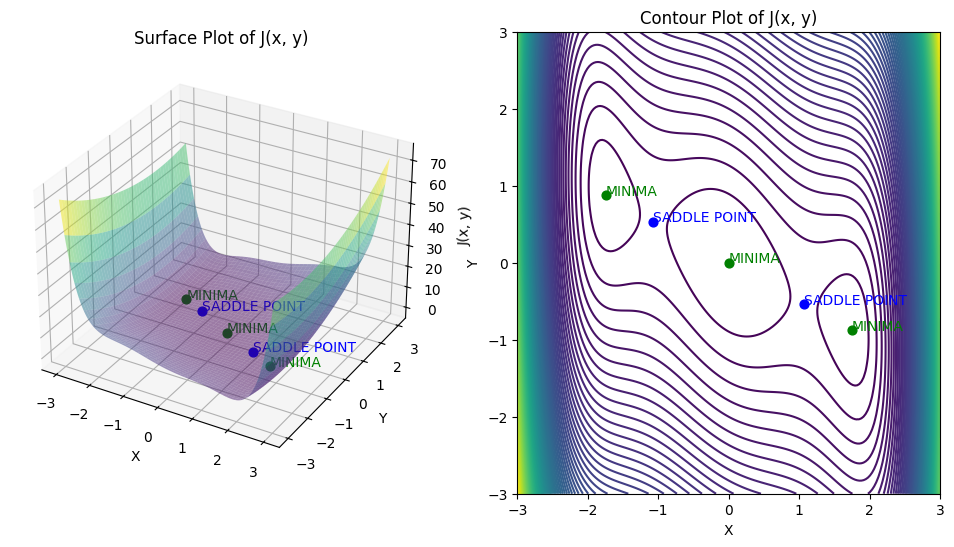

In [18]:
# Create a meshgrid of x and y values
x = np.linspace(-3, 3, 200)
y = np.linspace(-3, 3, 200)
X, Y = np.meshgrid(x, y)

# Calculate Z values for the surface and contour plots
Z = j([X, Y])

# Colormap for the points
points_colormap = { 'MINIMA': 'g', 'MAXIMA': 'r', 'SADDLE POINT': 'b' }

# Plotting the surface plot
fig = plt.figure(figsize=(12, 6))

# Add a subplot for the surface plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.5)
ax.set_title('Surface Plot of J(x, y)')
for point, point_type in zip(stationary_points, points_type):
	ax.scatter(point[0], point[1], float(j(point)), color=points_colormap[point_type], s=40) 
	ax.text(point[0], point[1], float(j(point)), f'{point_type}', color=points_colormap[point_type])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('J(x, y)')

# Add a subplot for the contour plot
ax2 = fig.add_subplot(1, 2, 2)
contour = ax2.contour(X, Y, Z, cmap='viridis', levels=100)
for point, point_type in zip(stationary_points, points_type):
	ax2.scatter(point[0], point[1], color=points_colormap[point_type], s=40) 
	ax2.text(point[0], point[1], f'{point_type}', color=points_colormap[point_type])
ax2.set_title('Contour Plot of J(x, y)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')

# Show the plot
plt.show()


3. **Implement Newton's Method**  
   Implement the Newton method for finding the minimum of a function. The input parameters should be:
   - The function $ J(x) $,
   - The gradient of $ J(x) $,
   - The Hessian of $ J(x) $,
   - The initial guess,
   - The tolerance,
   - The maximum number of iterations.

   The stopping criterion should be:
   $$
   |J(x^{(k+1)}) - J(x^{(k)})| < \epsilon.
   $$

   The output should include:
   - The history of the iterates $ x^{(k)} $,
   - The history of the corresponding functional values $ J(x^{(k)}) $.



In [19]:
def newton(J, x0, tolerance, max_iterations, lambda_reg=1e-8):
    x_k = x0
    x_history = [x_k]
    j_history = [J(x_k)]
    grad_jit = jax.jit(jax.grad(J))
    hess_jit = jax.jit(jax.jacfwd(jax.jacrev(J)))
    
    for _ in tqdm(range(max_iterations)):
        H = hess_jit(x_k)
        G = jnp.array(grad_jit(x_k))
        try:
            incr = np.linalg.solve(H, -G)
        except:
            H_reg = H + lambda_reg * np.eye(len(G))
            incr = np.linalg.solve(H_reg, -G)
        x_prev = x_k

        x_k = x_k + incr
        j_history.append(J(x_k))
        x_history.append(np.array(x_k))
        if abs(J(x_k) - J(x_prev)) < tolerance:
            print(f"convergence reached! {abs(J(x_k) - J(x_prev))} < {tolerance}")
            break
    return x_history, j_history

4. **Apply Newton's Method**  
   Apply the code developed in the previous step to the function $ J(x) $. Use the following parameters:
   - Tolerance $ \epsilon = 10^{-6} $,
   - Maximum number of iterations = 100,
   - Initial guesses:
     - $ x_0 = (2.5, -2.5) $,
     - $ x_0 = (0.8, -2.5) $,
     - $ x_0 = (-0.4, -2.5) $.

   For each initial guess:
   - Plot the convergence history on the contour plot.
   - Plot the history of the function values.

  0%|          | 0/100 [00:00<?, ?it/s]

convergence reached! 7.765139142801303e-08 < 1e-06


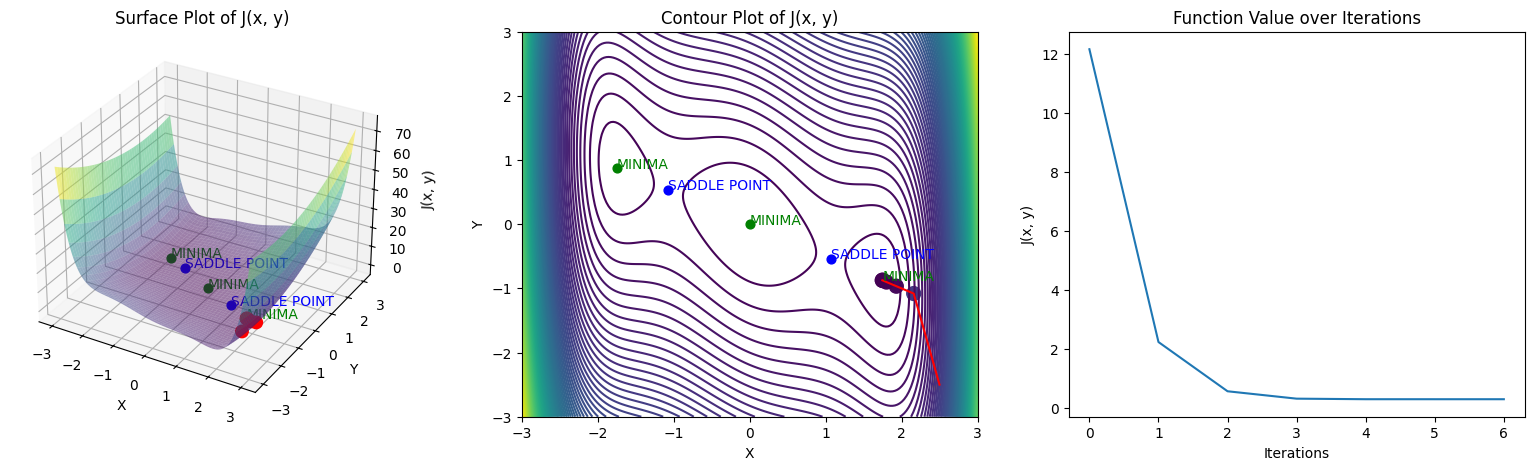

  0%|          | 0/100 [00:00<?, ?it/s]

convergence reached! 5.305755834683623e-12 < 1e-06


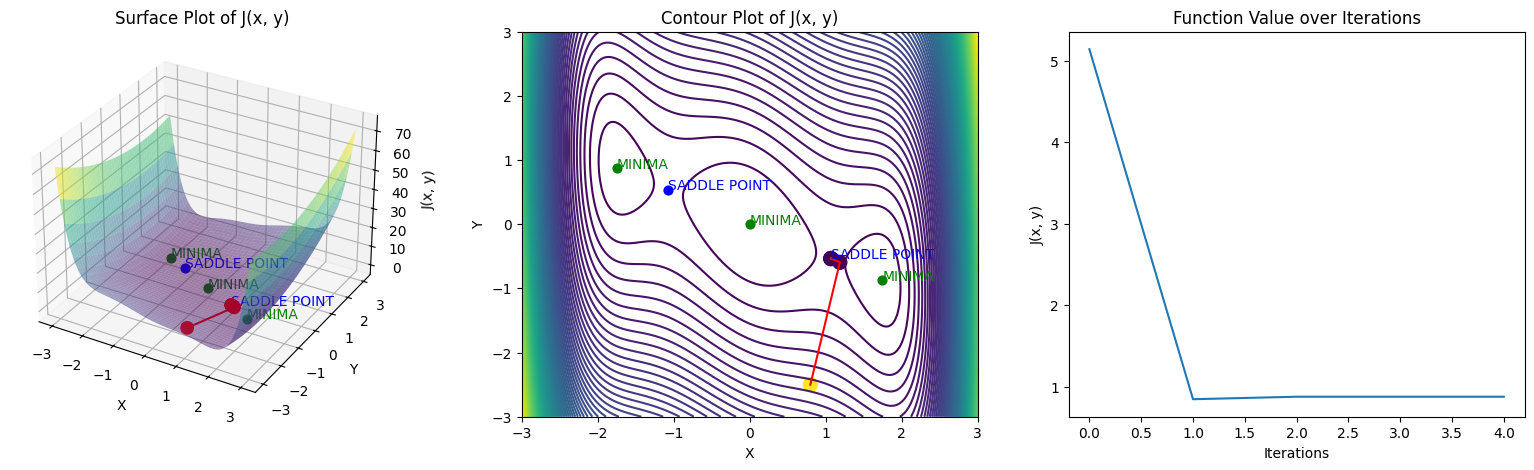

  0%|          | 0/100 [00:00<?, ?it/s]

convergence reached! 2.2615871876822788e-15 < 1e-06


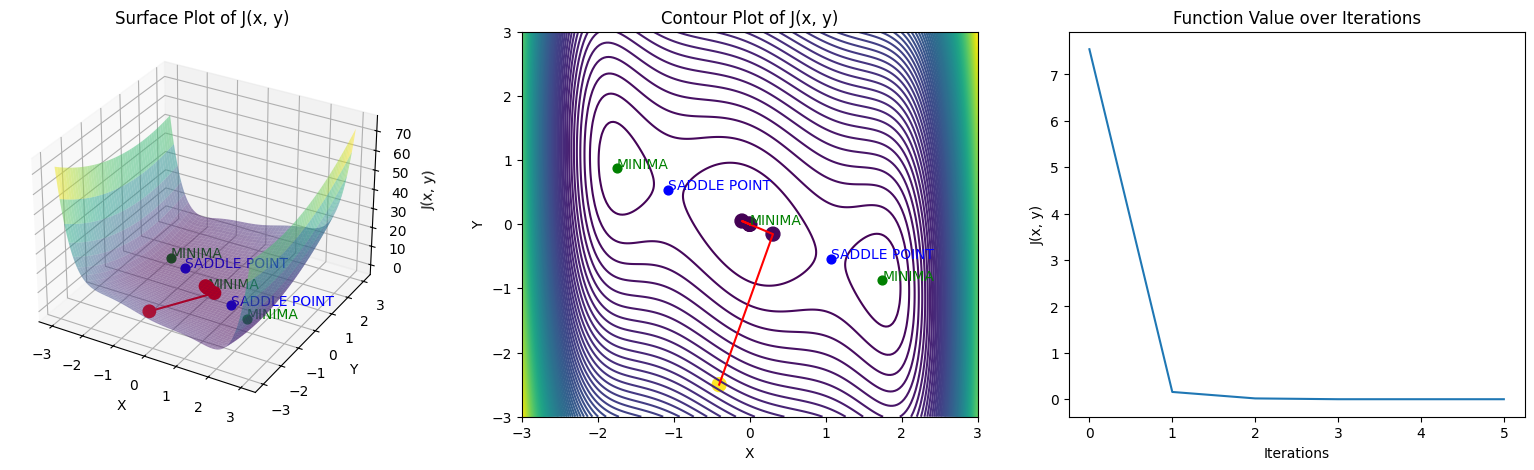

In [21]:
epsilon = 1e-6
x0 = [(2.5,-2.5),(0.8,-2.5),(-0.4,-2.5)]

for x in x0:
    x_history, J_history = newton(j, x, epsilon, max_iterations=100)
    x = np.array([el[0] for el in x_history])
    y = np.array([el[1] for el in x_history])
    J_history = np.array(J_history)

    # Plotting the surface plot
    fig = plt.figure(figsize=(20, 5))
    
    # Add a subplot for the surface plot
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.5)
    # minimas
    for point, point_type in zip(stationary_points, points_type):
        ax.scatter(point[0], point[1], float(j(point)), color=points_colormap[point_type], s=40) 
        ax.text(point[0], point[1], float(j(point)), f'{point_type}', color=points_colormap[point_type])
    ax.scatter(x, y, J_history, c='r', s=80, alpha=1)  # Bigger points in red
    ax.plot(x, y, J_history, c='r')  # Line between points in red
    ax.set_title('Surface Plot of J(x, y)')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('J(x, y)')
    
    # Add a subplot for the contour plot
    ax2 = fig.add_subplot(1, 3, 2)
    contour = ax2.contour(X, Y, Z, cmap='viridis', levels=100)
    for point, point_type in zip(stationary_points, points_type):
        ax2.scatter(point[0], point[1], color=points_colormap[point_type], s=40) 
        ax2.text(point[0], point[1], f'{point_type}', color=points_colormap[point_type])
    ax2.scatter(x, y, s=100, c=J_history, cmap='viridis')  # Bigger points in red
    ax2.plot(x, y, c='r')  # Line between points in red
    ax2.set_title('Contour Plot of J(x, y)')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')

    # Plot the history of the function values
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.plot(J_history)
    ax3.set_title('Function Value over Iterations')
    ax3.set_xlabel('Iterations')
    ax3.set_ylabel('J(x, y)')


    plt.show()

5. **Comment on the Results**  
   Provide an analysis and comments based on the behavior of Newton's method with the given initial points.

#### Comment:

The first point converges to one of the two local minima, the second point converges to a saddle point while only the third point converges to the global minimum.
In all three cases the convergence is very fast, this is to be expected since we are initializing the algorithm close to the minima/saddle points (Newton methods yields superlinear convergence when initializad properly on convex function, despite J not being convex this still suggest a fast conversion when initialize close to critical points).

---

# Exercise 3

Consider the following matrix:

$$
A = 
\begin{bmatrix}
3 & 6 \\
0 & 1 \\
4 & 8

\end{bmatrix}
$$

1. **QR Factorization Using Gram-Schmidt**  
   Compute, by hand, the QR factorization of the matrix $ A $ using the **Gram-Schmidt procedure**.

2. **Build the Projection Matrix**  
   Use the computed QR factorization to construct the **projection matrix** onto the range of $ A $ (i.e., the column space of $ A $).

3. **Column Space Membership Check**  
   Use the projection matrix to determine whether the vector $ b = [1, 1, 0]^T $ belongs to the column space of $ A $.

4. **Solve $ Ax = b $**  
   Use the QR factorization to find a solution (or best-fit solution) to $ Ax = b $.

5. **Solve $ A^T x = c $**  
   Consider $ c = [2, 2]^T $:
   - Check whether a solution exists to $ A^T x = c $.
   - If no solution exists, find the **best-fit solution**.
   - If one or more solutions exist, find the solution for which $ \|x\| $ is as small as possible.


<div align="center">
	<img src="3_image.png" width="600">
</div>